<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Подключение библиотек 

In [71]:
import pandas as pd
import re
import nltk

from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords as stpwrds

Загрузка необходимых ресурсов для дальнейшей работы

In [63]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Глобальные переменные

In [72]:
lemmatizer=WordNetLemmatizer()
RANDOM_STATE=42
stopwords_set = set(stpwrds.words('english'))

Загрузка данных

In [40]:
try:
    data=pd.read_csv('/datasets/toxic_comments.csv', index_col=[0])
except FileNotFoundError:
    data=pd.read_csv('toxic_comments.csv', index_col=[0])

Вывод датафрейма

In [41]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Информация о датафрейме

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Гистограмма классов

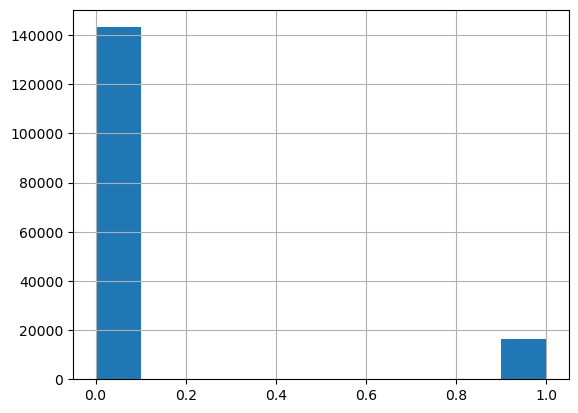

In [43]:
data['toxic'].hist();

На всякий случай просмотрим дубликаты в данных

In [44]:
data.duplicated().sum()

0

Для очистки данных от неявных дубликатов и для уменьшения словаря приведем текст в нижний регистр

In [45]:
data['text']=data['text'].str.lower()
data.head()

,text,toxic
0,explanation\nwhy the edits made under my usern...,0
1,d'aww! he matches this background colour i'm s...,0
2,"hey man, i'm really not trying to edit war. it...",0
3,"""\nmore\ni can't make any real suggestions on ...",0
4,"you, sir, are my hero. any chance you remember...",0


Функция очистки текста

In [46]:
def clear_text(text):
    broom = re.sub(r'[^a-zA-Z ]', ' ', text)
    broom = ' '.join(broom.split())
    return broom

Очистка теста

In [47]:
data['text']=data['text'].apply(clear_text)
data['text'].head()

0    explanation why the edits made under my userna...
1    d aww he matches this background colour i m se...
2    hey man i m really not trying to edit war it s...
3    more i can t make any real suggestions on impr...
4    you sir are my hero any chance you remember wh...
Name: text, dtype: object

Функция для лемматизации

In [48]:
def lemmatize(text):
    words = nltk.word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    lemmatized_text = " ".join(lemmatized_words)
    return lemmatized_text

Лемматизация текстов

In [49]:
data['text']=data['text'].apply(lemmatize)
data['text'].head()

0    explanation why the edits made under my userna...
1    d aww he match this background colour i m seem...
2    hey man i m really not trying to edit war it s...
3    more i can t make any real suggestion on impro...
4    you sir are my hero any chance you remember wh...
Name: text, dtype: object

На всякий случай посмотрим дубликаты после лемматизации

In [51]:
data.duplicated().sum()

1307

In [56]:
data[data.duplicated()].sort_values('text').tail(10)

,text,toxic
76115,you should wait for others to write an article...,0
156806,you suck,1
150510,you suck duck butt that s right i m talkin to ...,1
69871,your request to be unblocked ha been granted f...,0
122705,your request to be unblocked ha been granted f...,0
67718,your request to be unblocked ha been granted f...,0
144435,your request to be unblocked ha been granted f...,0
24622,your request to be unblocked ha been granted f...,0
131665,your stalker friend is back the hostile user y...,0
94518,zionist jew please stop spreadin your lie bias...,1


Дубликаты обнаружены. Устраним их. И выведем информацию о данных после данного процесса

In [58]:
data.drop_duplicates(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 157985 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    157985 non-null  object
 1   toxic   157985 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Разделим данные на обучающую и тестовую выборку

In [62]:
train, test=train_test_split(data, test_size=0.3, random_state=RANDOM_STATE)

In [73]:
corpus_train = train['text'].values
corpus_test = test['text'].values

In [74]:
target_train = train['toxic']
target_test = test['toxic']

## Обучение

## Выводы

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны